## Bayesian Gaussian Process Latent Variable Model

We'll do dimensional reduction on single cell dataset to show to usefulness of informative prior and show that GPLVM can capture branching too.

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats

smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('0.3.0')
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(1)

### Data

In [2]:
# data is stored in Open Data Science repository
URL = "https://raw.githubusercontent.com/sods/ods/master/datasets/guo_qpcr.csv"
df = pd.read_csv(URL, index_col=0)
df.head()

,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
1,0.541050,-1.203007,1.030746,1.064808,0.494782,-0.167143,-1.369092,1.083061,0.668057,-1.553758,...,-1.351757,-1.793476,0.783185,-1.408063,-0.031991,-0.351257,-1.078982,0.942981,1.348892,-1.051999
1,0.680832,-1.355306,2.456375,1.234350,0.645494,1.003868,-1.207595,1.208023,0.800388,-1.435306,...,-1.363533,-1.782172,1.532477,-1.361172,-0.501715,1.082362,-0.930112,1.064399,1.469397,-0.996275
1,1.056038,-1.280447,2.046133,1.439795,0.828121,0.983404,-1.460032,1.359447,0.530701,-1.340283,...,-1.296802,-1.567402,3.194157,-1.301777,-0.445219,0.031284,-1.005767,1.211529,1.615421,-0.651393
1,0.732331,-1.326911,2.464234,1.244323,0.654359,0.947023,-1.265609,1.215373,0.765212,-1.431401,...,-1.684100,-1.915556,2.962515,-1.349710,1.875957,1.699892,-1.059458,1.071541,1.476485,-0.699586
1,0.629333,-1.244308,1.316815,1.304162,0.707552,1.429070,-0.895578,-0.007785,0.644606,-1.381937,...,-1.304653,-1.761825,1.265379,-1.320533,-0.609864,0.413826,-0.888624,1.114394,1.519017,-0.798985


In [3]:
# get number of cells and number of genes
N, C = df.shape
N

437

In [4]:
data = torch.tensor(df.values, dtype=torch.get_default_dtype())
y = data.t()

In [5]:
pseudotime = [int(cell_name.split(" ")[0]) for cell_name in df.index.values]

In [6]:
X_init = torch.zeros(N, 2)
X_init[:, 0] = (y.new_tensor(pseudotime).log2() - 1) / 5

In [7]:
kernel = gp.kernels.RBF(input_dim=2, lengthscale=torch.ones(2))

# we will use VariationalSparseGP model with num_inducing=32
Xu = stats.resample(X_init, 32).clone()

gpmodel = gp.models.SparseGPRegression(X_init, y, kernel, Xu, noise=torch.tensor(0.01),
                                       jitter=1e-5)

gplvm = gp.models.GPLVM(gpmodel)
gplvm.set_prior("X", dist.Normal(X_init.clone(), 0.1).to_event(2))
gplvm.autoguide("X", dist.Normal)
optimizer = torch.optim.Adam(gplvm.parameters(), lr=0.01)
losses = gp.util.train(gplvm, optimizer, num_steps=4000)

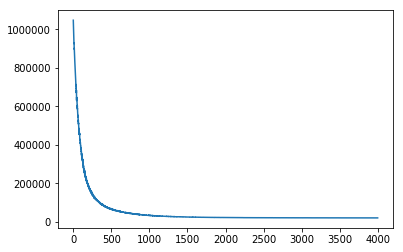

In [11]:
plt.plot(losses);

In [9]:
X = gplvm.X_loc

### Visualize the result

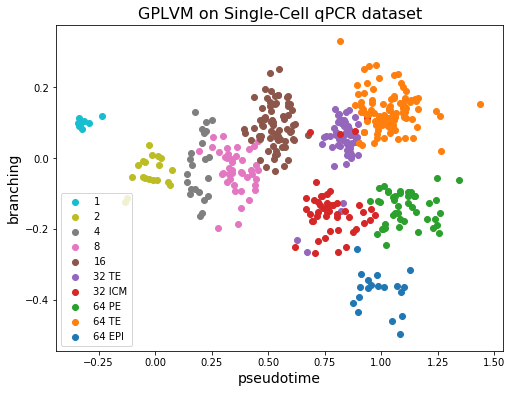

In [10]:
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab10").colors[::-1]
labels = df.index.unique()

X = X.detach().numpy()
for i, label in enumerate(labels):
    X_i = X[df.index == label]
    plt.scatter(X_i[:, 0], X_i[:, 1], c=colors[i], label=label)

plt.legend()
plt.xlabel("pseudotime", fontsize=14)
plt.ylabel("branching", fontsize=14)
plt.title("GPLVM on Single-Cell qPCR dataset", fontsize=16);

### References

[1] `GrandPrix: Scaling up the Bayesian GPLVM for single-cell data`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Sumon Ahmed, Magnus Rattray, Alexis Boukouvalas

[2] `Resolution of Cell Fate Decisions Revealed by Single-Cell Gene Expression Analysis from Zygote to Blastocyst`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Guoji Guo, Mikael Huss, Guo Qing Tong, Chaoyang Wang, Li Li Sun, Neil D. Clarke, Paul Robson

[3] `Bayesian Gaussian Process Latent Variable Model`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Michalis K. Titsias, Neil D. Lawrence